# Analyse en composantes principales (ACP) de recettes de cuisine

L'objectif de ce notebook Jupyter est d'illustrer l'analyse en composantes principales (ACP) en Python. Le traitement mathématique de l'ACP (matrice de covariance, valeurs et vecteurs propres...) et sa résolution numérique (`numpy.linalg.eig()`) ne seront pas (ou peu) abordés. Ces concepts sont néanmoins très bien traités en Python dans cette vidéo [PCA (Principal Component Analysis) in Python](https://www.youtube.com/watch?v=52d7ha-GdV8).

Le jeu de données proposé est une liste de de plats sucrés : flan, brioche... Pour chaque recette, seuls les principaux ingrédients sont fournis.

## Modules Python utilisés

Chargeons d'abord les modules Python nécessaires pour cette analyse

In [1]:
# Numpy pour le calcul sur vecteur et matrice
import numpy as np

# Pandas pour le chargement du jeu de données et sa manipulation
import pandas as pd

# Matplotlib pour les graphiques (de base)
import matplotlib.pyplot as plt

# Bokeh pour les graphiques interactifs
from bokeh.io import output_notebook, show
from bokeh.models import HoverTool
from bokeh.plotting import figure
# https://docs.bokeh.org/en/latest/docs/user_guide/jupyter.html
output_notebook()

# Scikit-learn (sklearn) pour la partie ACP à proprement dit
import sklearn.preprocessing
import sklearn.decomposition

Loading BokehJS ...

## Jeu de données

Ouvrons le jeu de données au format `.xlsx` :

In [2]:
recipe_df = pd.read_excel("recettes_cuisine.xlsx", index_col=0)

Affichons maintenant les premières lignes du jeu de données :

In [3]:
recipe_df.head()

,Catégorie,Farine (g),Sucre (g),Oeufs (unité),Beurre (g),Eau (mL),Lait (mL),Levure de boulanger (g),Levure chimique (sachet),Commentaire,Contact,Source
Recettes,,,,,,,,,,,,
Flan pâtissier,flan,90,150,4.0,0,0,1000,0,0.0,On utilise normalement de la fécule de mais (M...,Pierre,https://www.marmiton.org/recettes/recette_flan...
Miasson,flan,140,150,3.0,45,0,500,0,0.0,+ 2 c-à-s d'eau de fleur d'oranger (soit 30 mL),Pierre,NaN
Flognarde,flan,100,200,4.0,0,0,500,0,0.0,NaN,Pierre,https://www.marmiton.org/recettes/recette_flog...
Brioche de Nanterre,brioche,250,25,3.0,100,0,0,12,0.0,NaN,Pierre,https://www.750g.com/brioche-de-nanterre-r9750...
Cannelés,flan,50,125,1.5,25,0,250,0,0.0,"Le jaune d'oeuf est représenté par 0,5 oeuf",Pierre,https://www.marmiton.org/recettes/recette_cann...


Pour chaque recette, nous avons la quantité nécessaire pour chaque ingrédient. Les unités des ingrédients ne sont pas identiques (g, mL...), ce n'est pas un problème pour l'ACP.

Chaque recette est également classée dans une grande catégorie suivant sa « texture » finale :

- brioche
- flan
- cake

On va sélectionner uniquement les recettes (lignes) dont les catégories nous intéressent :

In [4]:
category_selected = ["brioche", "flan", "cake"]

In [5]:
recipe_df = recipe_df[ recipe_df["Catégorie"].isin(category_selected) ]

On affiche le nombre de recettes par catégorie :

In [6]:
recipe_df["Catégorie"].value_counts()

brioche    8
cake       7
flan       7
Name: Catégorie, dtype: int64

## Analyse en composantes principales

Dans ce jeu de données, les différentes grandeurs n'ont pas grand chose à voir les unes avec les autres. Il peut donc être utile de centrer et réduire le jeu de données, c'est-à-dire de faire en sorte que, pour chaque ingrédient, la moyenne des valeurs soit égal à 0 et l'écart type à 1.

Pour un ingrédient donné, si $X$ est la valeur initiale pour une recette, $\mu$ la moyenne et $\sigma$ l'écart-type, alors la nouvelle valeur $x$ vaut :

$$x = \frac{X - \mu}{\sigma}$$

Cette opération est fournie *clé en main* par la méthode `StandardScaler()` de la bibliothèque Scikit-learn que nous utilisons ici.

Par ailleurs, nous allons réaliser l'ACP uniquement sur des ingrédients (colonnes) pertinents :

In [7]:
ingredient_selected = ["Farine (g)", "Sucre (g)", "Oeufs (unité)", "Beurre (g)", 
                       "Eau (mL)", "Lait (mL)", 
                       "Levure de boulanger (g)", "Levure chimique (sachet)"]

In [8]:
recipe_array = sklearn.preprocessing.StandardScaler().fit_transform(recipe_df[ingredient_selected])

On réalise maintenant l'ACP a proprement dite. Le calcul des valeurs et vecteurs propres est réalisé automatiquement par Scikit-learn.

In [9]:
pca = sklearn.decomposition.PCA()

pca_array = pca.fit_transform(recipe_array)
print("Dimensions de la matrice après ACP : {} x {}".format(*pca_array.shape))
print("Type de la matrice :", type(pca_array))

Dimensions de la matrice après ACP : 22 x 8
Type de la matrice : <class 'numpy.ndarray'>


On obtient un objet `ndarray` de NumPy, constitué de 22 lignes (les recettes) et 8 colonnes (les coordonnées sur chaque composante principale).

Pour faciliter les manipulations ultérieures, on va transformer cet objet `ndarray` en *dataframe* de Pandas.

In [10]:
pca_df = pd.DataFrame(data=pca_array, 
                      columns=[f"component{idx+1}" for idx in range(pca_array.shape[1])])
pca_df.index = recipe_df.index
pca_df["category"] = recipe_df["Catégorie"]
pca_df["name"] = recipe_df.index
pca_df.head()

,component1,component2,component3,component4,component5,component6,component7,component8,category,name
Recettes,,,,,,,,,,
Flan pâtissier,-0.066537,-3.270363,1.661164,1.727388,0.766526,-0.373374,-0.472182,-0.214930,flan,Flan pâtissier
Miasson,0.058456,-1.789452,0.518250,0.403710,0.423331,0.406534,-0.100718,0.055350,flan,Miasson
Flognarde,0.580388,-2.195722,1.188200,0.471799,0.242291,0.315927,0.735553,-0.068888,flan,Flognarde
Brioche de Nanterre,-1.121162,0.287792,-0.242166,-0.938474,-1.192243,0.033821,-0.353722,-0.215709,brioche,Brioche de Nanterre
Cannelés,-0.362523,-1.662259,-0.588377,-0.876214,0.742676,0.797873,0.030920,-0.114018,flan,Cannelés


Dans l'ACP, chaque composante principale (vecteur propre) *explique* une partie de la variance totale du jeu de données.
Scikit-learn nous renvoie les composantes principales dans l'ordre, c'est-à-dire que la première composante est celle qui *explique* le plus de variance du jeu de données.

La variable `explained_variance_ratio_` fournit le proportion de variance expliquée par chaque composante.

In [11]:
print("Proportion de la variance expliquée par chaque composante principale :", 
      pca.explained_variance_ratio_, 
      sep="\n")

Proportion de la variance expliquée par chaque composante principale :
[0.35115903 0.30506784 0.14185736 0.0894352  0.07201556 0.02018447
 0.01154733 0.00873321]


Ainsi, la première composante explique 35,1 % de la variance, la deuxième 30,5 %, la troisième 14,2 %, etc.

Une autre mesure intéressante est la variance cumulée expliquée par les n-premières composantes principales.

In [12]:
print("Somme cumulative de la variance expliquée par les composantes principales :", 
      pca.explained_variance_ratio_.cumsum(), 
      sep="\n")

Somme cumulative de la variance expliquée par les composantes principales :
[0.35115903 0.65622688 0.79808423 0.88751944 0.959535   0.97971946
 0.99126679 1.        ]


Ici, les deux premières composantes expliquent 65,6 % de la variance, les 3 premières 79,8 %, etc.

## Visualisation des données

Pour commencer, on va visualiser notre analyse avec Matplotlib.

On représente chaque catégorie de recettes avec une couleur particulière pour voir si notre ACP est capable de retrouver cette distinction initiale de texture. Ce n'est pas évident a priori car on ne dit pas à l'algorithme dans quelle catégorie est chaque recette. On parle ici d'apprentissage non supervisé.

In [13]:
color_dict = {"brioche": "orange", "flan": "yellow", "cake": "red", "autre": "purple"}

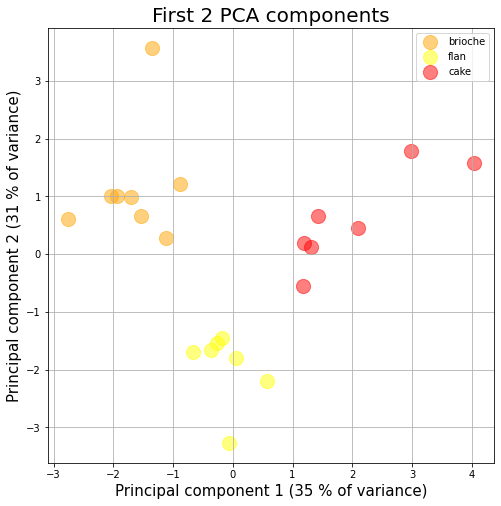

In [14]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel(f"Principal component 1 ({100*pca.explained_variance_ratio_[0]:.0f} % of variance)", fontsize = 15)
ax.set_ylabel(f"Principal component 2 ({100*pca.explained_variance_ratio_[1]:.0f} % of variance)", fontsize = 15)
ax.set_title("First 2 PCA components", fontsize = 20)
for category in category_selected:
    ax.scatter(pca_df.loc[pca_df["category"] == category, "component1"], 
               pca_df.loc[pca_df["category"] == category, "component2"], 
               s=200, alpha=0.5, c=color_dict[category], label=category)
ax.legend()
ax.grid()

Les recettes apparaissent regroupées par catégorie. La notion de texture (flan, brioche, cake) est sans doute expliquée par la composition des différents ingrédients, ce qui semble logique.

## Visualisation interactive des données

La bibliothèque *Bokeh* permet de constuire des graphiques interactifs, propices à l'exploration des données.

In [15]:
comp_first = 1
comp_second = 2

p = figure(plot_width=600, plot_height=600,
           title=f"Projection des recettes sur axes des composantes {comp_first} et {comp_second}")

p.xaxis.axis_label = f"Principal component {comp_first} ({100*pca.explained_variance_ratio_[comp_first-1]:.0f} % of variance)"
p.yaxis.axis_label = f"Principal component {comp_second} ({100*pca.explained_variance_ratio_[comp_second-1]:.0f} % of variance)"

for category in category_selected:
    p.circle(x=f"component{comp_first}", y=f"component{comp_second}", source=pca_df[pca_df["category"] == category], 
             size=15, color=color_dict[category], alpha=0.5,
             legend_label=category)
p.add_tools(HoverTool())

hover = p.select(dict(type=HoverTool))
hover.tooltips = [("name", "@name"), ("category", "@category")]
hover.mode = 'mouse'

p.legend.location = "bottom_right"
p.legend.click_policy = "hide"

show(p)

Les catégories apparaissent ici encore nettement.

On peut passer la souris au dessus d'un point pour connaître le nom de la recette.

La barre d'outils à droite permet de zoomer et de se déplacer dans le graphique.

## Visualisation des composantes principales

Les composantes principales (ou vecteurs propres) sont disponibles dans la variable `components_`

In [16]:
pca.components_

array([[-0.22467873,  0.52735416,  0.31709382,  0.31855323, -0.10487322,
        -0.12167131, -0.44591441,  0.49472259],
       [ 0.51117016,  0.0581805 , -0.04004731,  0.50439793,  0.31964108,
        -0.44519541,  0.38465306,  0.17598775],
       [-0.08981881,  0.13926414,  0.64616322, -0.00115141,  0.61434104,
         0.25318955,  0.09719056, -0.32255851],
       [ 0.49671227,  0.28656638,  0.09245755,  0.17563576, -0.39725012,
         0.66441939,  0.17994964, -0.01084715],
       [-0.04599508,  0.35341922, -0.6178172 , -0.12193288,  0.54849292,
         0.34687693, -0.05556954,  0.22838021],
       [-0.16732634,  0.4258014 , -0.28070225,  0.35192734, -0.12284647,
        -0.17206933, -0.09540617, -0.73092203],
       [ 0.19834704,  0.54785031,  0.10547574, -0.67371046, -0.11093646,
        -0.35310044,  0.24101208, -0.02083094],
       [ 0.60330659, -0.10317893,  0.01246764, -0.14370474,  0.15285938,
        -0.08262979, -0.7355932 , -0.1824219 ]])

C'est un objet de type *array* de Numpy. Chaque composante est une combinaison linéaire des ingrédients initiaux.

La première composante est constituée de -0.22467873 de `Farine (g)`, de 0.52735416 de `Sucre (g)`, de 0.31709382 de `Oeufs (unité)`, etc.

Pour rendre la constitution des différentes composantes principales plus lisible, on peut transformer cet objet en *dataframe* *pandas*.

In [17]:
component_df = pd.DataFrame(data=pca.components_, 
                            index=[f"component{idx+1}" for idx in range(pca_array.shape[1])],
                            columns=ingredient_selected)
component_df

,Farine (g),Sucre (g),Oeufs (unité),Beurre (g),Eau (mL),Lait (mL),Levure de boulanger (g),Levure chimique (sachet)
component1,-0.224679,0.527354,0.317094,0.318553,-0.104873,-0.121671,-0.445914,0.494723
component2,0.511170,0.058180,-0.040047,0.504398,0.319641,-0.445195,0.384653,0.175988
component3,-0.089819,0.139264,0.646163,-0.001151,0.614341,0.253190,0.097191,-0.322559
component4,0.496712,0.286566,0.092458,0.175636,-0.397250,0.664419,0.179950,-0.010847
component5,-0.045995,0.353419,-0.617817,-0.121933,0.548493,0.346877,-0.055570,0.228380
component6,-0.167326,0.425801,-0.280702,0.351927,-0.122846,-0.172069,-0.095406,-0.730922
component7,0.198347,0.547850,0.105476,-0.673710,-0.110936,-0.353100,0.241012,-0.020831
component8,0.603307,-0.103179,0.012468,-0.143705,0.152859,-0.082630,-0.735593,-0.182422


On peut rendre cela plus visuel avec un gradient de couleurs. Pour une composante donnée, le rouge indique qu'un ingrédient est important et le bleu qu'un ingrédient est moins présent.

In [18]:
component_df.style.set_precision(2).background_gradient(cmap="bwr", vmin=-1, vmax=1)

,Farine (g),Sucre (g),Oeufs (unité),Beurre (g),Eau (mL),Lait (mL),Levure de boulanger (g),Levure chimique (sachet)
component1,-0.22,0.53,0.32,0.32,-0.10,-0.12,-0.45,0.49
component2,0.51,0.06,-0.04,0.50,0.32,-0.45,0.38,0.18
component3,-0.09,0.14,0.65,-0.00,0.61,0.25,0.10,-0.32
component4,0.50,0.29,0.09,0.18,-0.40,0.66,0.18,-0.01
component5,-0.05,0.35,-0.62,-0.12,0.55,0.35,-0.06,0.23
component6,-0.17,0.43,-0.28,0.35,-0.12,-0.17,-0.10,-0.73
component7,0.20,0.55,0.11,-0.67,-0.11,-0.35,0.24,-0.02
component8,0.60,-0.10,0.01,-0.14,0.15,-0.08,-0.74,-0.18


La première composante est constituée essentiellement de sucre, de levure chimique, d'oeuf et de beurre.

La deuxième composante est constituée essentiellement de farine, de beurre et levure de boulanger.

## Propriété des composantes principales

Une propriété importante des composantes principales est que ce sont des vecteurs orthogonaux. C'est-à-dire que le produit scalaire de deux vecteurs propres est nul. On peut le vérifier en calculant le produit scalaire de tous les couples possibles de vecteurs propres.

In [19]:
for i in range(pca.components_.shape[0]):
    for j in range(i+1, pca.components_.shape[0]):
        print(f"Produit scalaire composante {i+1} x {j+1} : {np.dot(pca.components_[i], pca.components_[j]):.6f}")

Produit scalaire composante 1 x 2 : -0.000000
Produit scalaire composante 1 x 3 : -0.000000
Produit scalaire composante 1 x 4 : 0.000000
Produit scalaire composante 1 x 5 : 0.000000
Produit scalaire composante 1 x 6 : 0.000000
Produit scalaire composante 1 x 7 : 0.000000
Produit scalaire composante 1 x 8 : -0.000000
Produit scalaire composante 2 x 3 : -0.000000
Produit scalaire composante 2 x 4 : 0.000000
Produit scalaire composante 2 x 5 : 0.000000
Produit scalaire composante 2 x 6 : -0.000000
Produit scalaire composante 2 x 7 : -0.000000
Produit scalaire composante 2 x 8 : -0.000000
Produit scalaire composante 3 x 4 : 0.000000
Produit scalaire composante 3 x 5 : 0.000000
Produit scalaire composante 3 x 6 : -0.000000
Produit scalaire composante 3 x 7 : 0.000000
Produit scalaire composante 3 x 8 : 0.000000
Produit scalaire composante 4 x 5 : 0.000000
Produit scalaire composante 4 x 6 : 0.000000
Produit scalaire composante 4 x 7 : -0.000000
Produit scalaire composante 4 x 8 : -0.000000


## Documentation et références supplémentaires

L'analyse en composantes principales avec Python :

- [Python Data Science Handbook - In Depth: Principal Component Analysis](https://jakevdp.github.io/PythonDataScienceHandbook/05.09-principal-component-analysis.html)
- [Understanding PCA (Principal Component Analysis) with Python](https://towardsdatascience.com/dive-into-pca-principal-component-analysis-with-python-43ded13ead21)
- [PCA using Python (scikit-learn)](https://towardsdatascience.com/pca-using-python-scikit-learn-e653f8989e60) (avec vidéo)
- [Scikit-learn: Principal component analysis (PCA)](https://scikit-learn.org/stable/modules/decomposition.html#pca)

Visualisation avec Bokeh

- [Outil `HoverTool`](https://docs.bokeh.org/en/latest/docs/user_guide/tools.html#hovertool)


Formatage d'un dataframe Pandas avec `.background_gradient()` :
- [Style Pandas Dataframe Like a Master](https://towardsdatascience.com/style-pandas-dataframe-like-a-master-6b02bf6468b0)
- [Choosing Colormaps in Matplotlib](https://matplotlib.org/tutorials/colors/colormaps.html)

## Informations de session

Par soucis de reproductibilité, il est utile de connaître la version de Python employée ainsi que celle des principales biliothèques. Ces informations sont fournies par le module [watermark](https://github.com/rasbt/watermark).

In [20]:
%load_ext watermark
%watermark -t -d -v -m
print("")
%watermark -w -p numpy,pandas,matplotlib,sklearn,bokeh,jupyterlab

Python implementation: CPython
Python version       : 3.7.10
IPython version      : 7.21.0

Compiler    : GCC 7.3.0
OS          : Linux
Release     : 5.8.0-44-generic
Machine     : x86_64
Processor   : x86_64
CPU cores   : 8
Architecture: 64bit


numpy     : 1.19.2
pandas    : 1.2.3
matplotlib: 3.3.4
sklearn   : 0.24.1
bokeh     : 2.3.0
jupyterlab: 2.2.6

Watermark: 2.2.0

